# Overview #

The objective of this task is to build a model that predicts the quality of red wine given certain features. Wine quality ranges from 0 (poor) to 10 (excellent).

# Import libraries & define some variables #

In [5]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

TRAIN_DATASET = os.path.join('dataset', 'winequality_red.csv')

# Data Inspection and Preprocessing #

In [6]:
df = pd.read_csv(TRAIN_DATASET)
df.head()


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
fixed acidity           1599 non-null float64
volatile acidity        1599 non-null float64
citric acid             1599 non-null float64
residual sugar          1599 non-null float64
chlorides               1599 non-null float64
free sulfur dioxide     1599 non-null float64
total sulfur dioxide    1599 non-null float64
density                 1599 non-null float64
pH                      1599 non-null float64
sulphates               1599 non-null float64
alcohol                 1599 non-null float64
quality                 1599 non-null int64
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


Luckily, this dataset does not have any `NaN` values and all inputs are numeric.

# Exploratory Data Analysis #

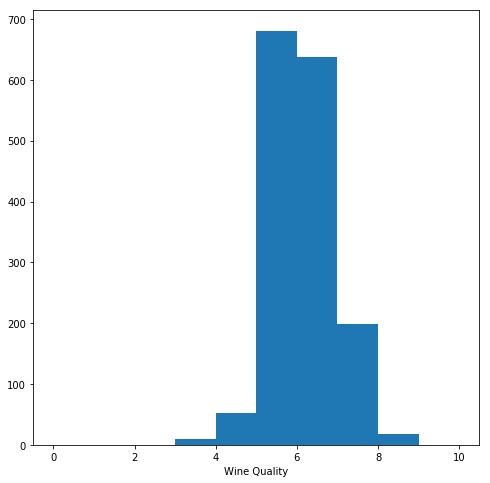

In [8]:
plt.figure(figsize=(8, 8))
plt.hist(df['quality'], range=(0, 10))
plt.xlabel('Wine Quality')
plt.show()

Most of the red wine samples provided fall between 5 and 7; meaning that they are mostly good wine (not excellent). This could affect the strength of prediction of the model since it will learn more of what makes red wine good.

Studying the correlation between the features will give an idea of what features really affect wine quality positively or negatively.

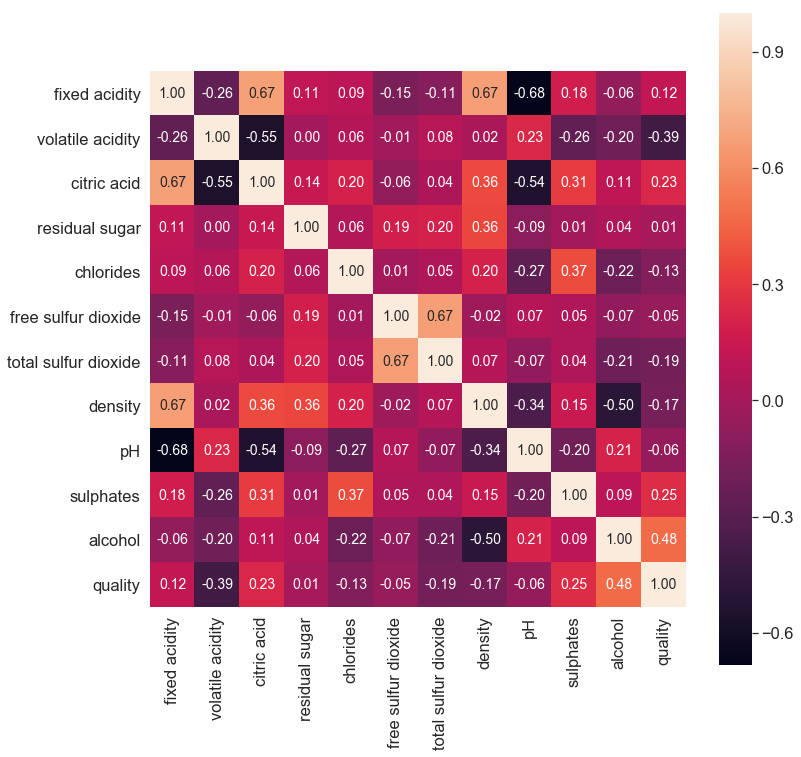

In [9]:
def heatmap(df):
    plt.figure(figsize=(12, 12))
    sns.set(font_scale=1.5)
    sns.heatmap(df.corr(), cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 14}, yticklabels=df.columns, 
                xticklabels=df.columns)
    plt.show()
    
heatmap(df)

We will exam features with strong correlation (>=0.45) between them.

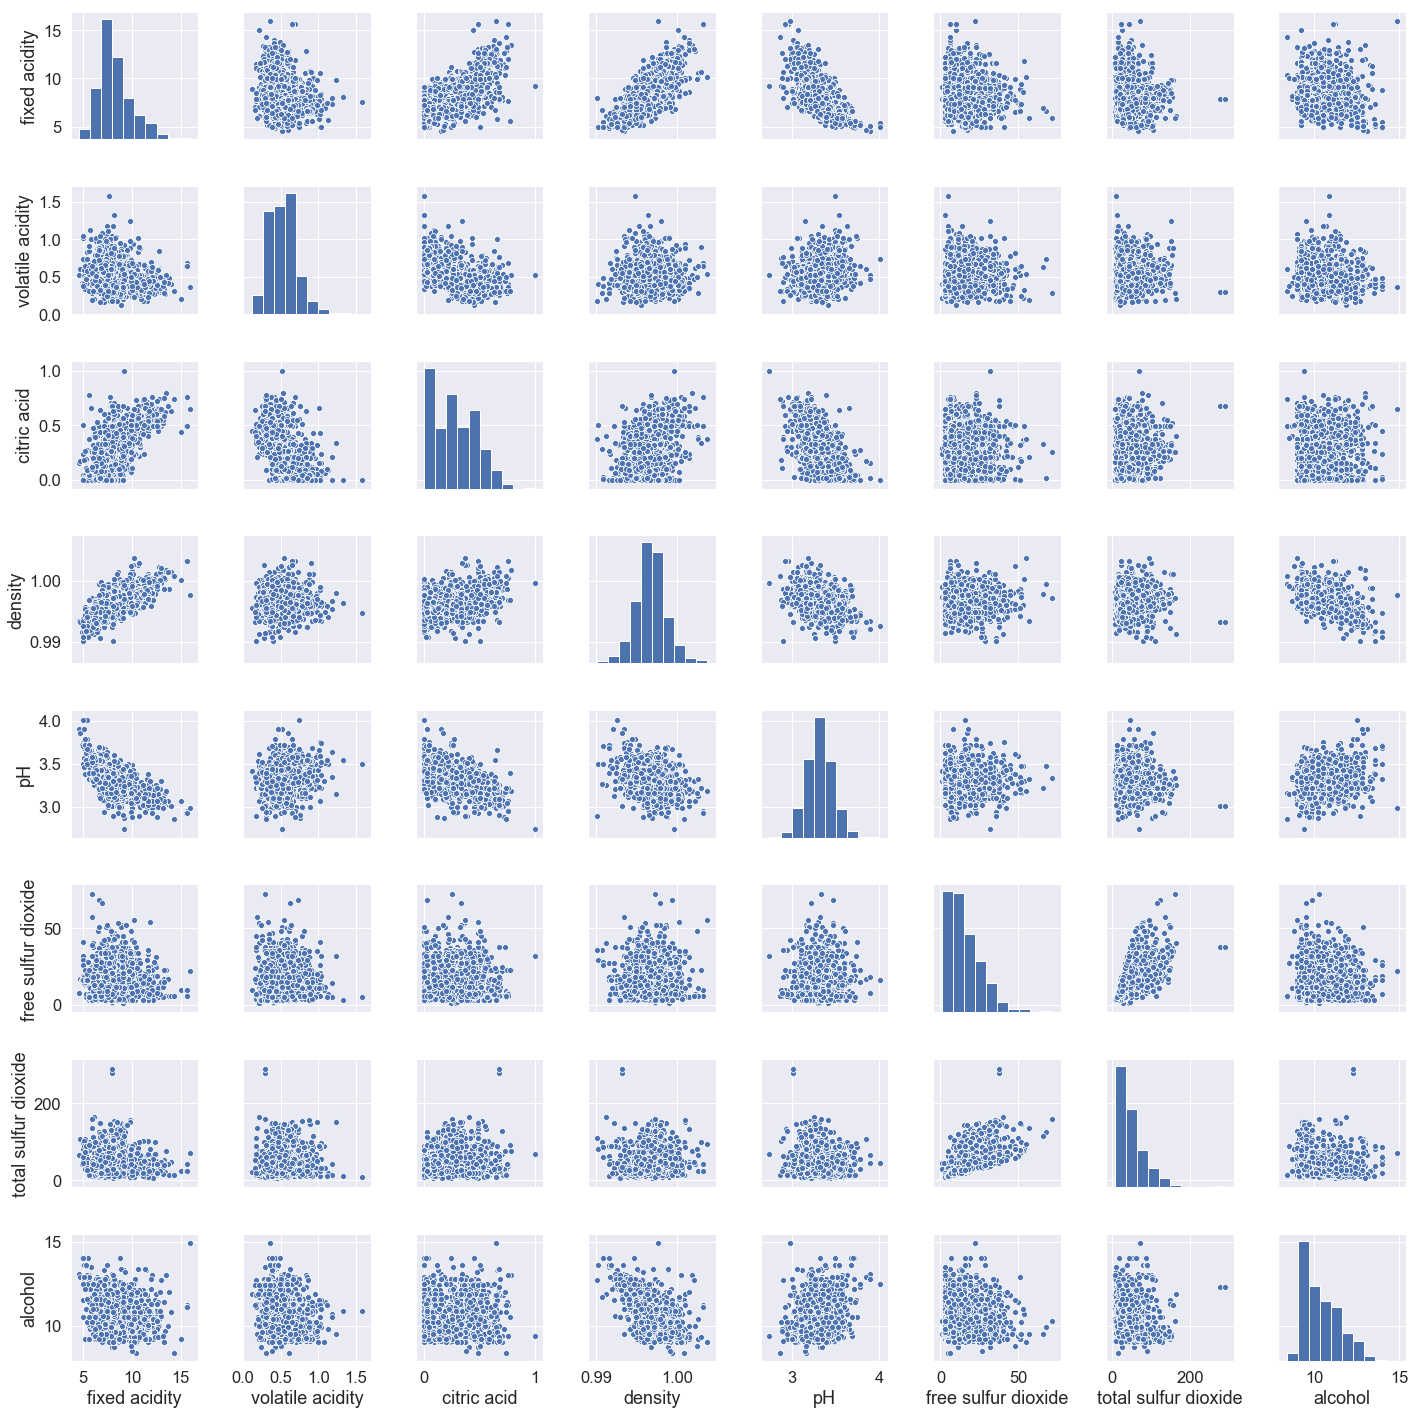

In [10]:
corr_cols = ['fixed acidity', 'volatile acidity', 'citric acid', 'density', 'pH', 'free sulfur dioxide', 
             'total sulfur dioxide', 'alcohol']

def pairplot(cols):
    sns.pairplot(df[cols])
    plt.show()
    
pairplot(corr_cols)

# Looking out for outliers #

The approach to be applied to looking for outliers will be to compare correlations between features and view the plot of points between these correlations. Correlation values greater than 0.5 and have "eye-balled" outliers from the pairplot will be analyzed.

In [11]:
from scipy import stats
from scipy.optimize import curve_fit
from numpy.polynomial.polynomial import polyfit
import random

def plot_relationship_best_fit(x_axis, x_label, y_axis, y_label, best_fit='linear'):
    fit = None
    
    if best_fit == 'linear':
        slope, intercept, r_value, p_value, std_err = stats.linregress(x_axis, y_axis)
        fit = slope * x_axis + intercept
#         c = polyfit(x_axis, y_axis, 1)
#         fit = c[0] + c[1]*x_axis
    
    if best_fit == 'quadratic':
        popt, pcov = curve_fit(func, x_axis, y_axis)
        fit = func(x_axis, *popt)
        
#         coef = polyfit(x_axis, y_axis, 2)
#         fit = coef[0] + coef[1]*x_axis + coef[2]*(x_axis**2)
        
    np.random.seed(42)
    r = random.randint(0, len(x_axis)-1)
    
    plt.figure(figsize=(8,8))    
    plt.scatter(x_axis, y_axis)
    plt.plot(x_axis, fit, color='r')
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.show()
    
def func(x, a, b, c):
    return a*(x**2) + b*x + c

In [12]:
def corr_plot(x_axis, x_label, y_axis, y_label, title=None, legend=None):
    plt.figure(figsize=(8, 8))
    plt.scatter(x_axis, y_axis)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    plt.show()

#### Fixed Acidity & Citric Acid ####

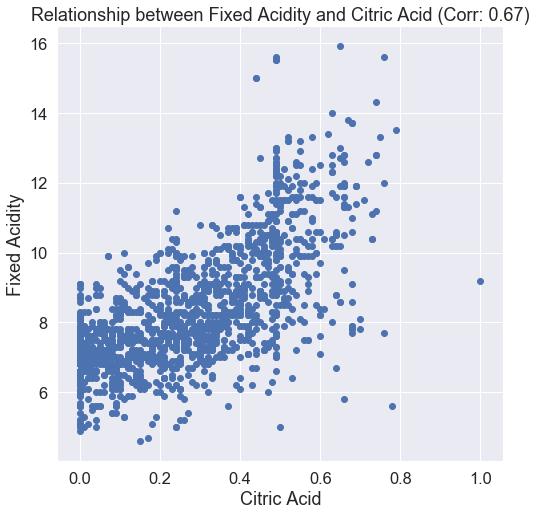

In [13]:
corr = 'Corr: %.2f' % df['fixed acidity'].corr(df['citric acid'])
corr_plot(df['citric acid'], 'Citric Acid', df['fixed acidity'], 'Fixed Acidity', 
          'Relationship between Fixed Acidity and Citric Acid ({})'.format(corr))

We would expect that as the citric acid content increase, so does the fixed acidity because of a strong positive correlation between the two. From the plot, there are anomalies when citric acid is 0 (vertical line), 0.49 (vertical line) and 1.0. These points will be removed.

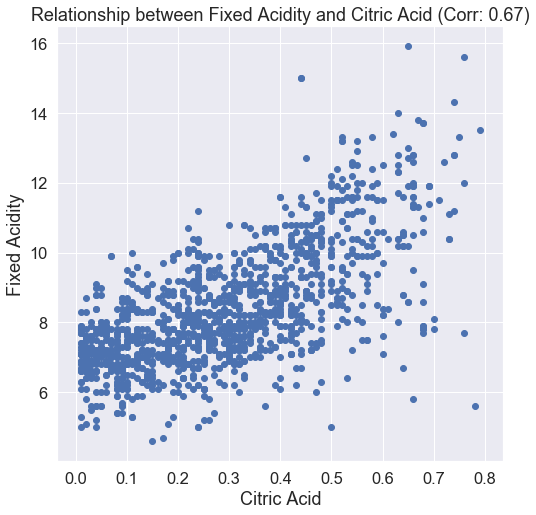

In [14]:
df = df[df['citric acid'] > 0]
df = df[df['citric acid'] != 0.49]
df = df[df['citric acid'] < 1.0]

corr = 'Corr: %.2f' % df['fixed acidity'].corr(df['citric acid'])
corr_plot(df['citric acid'], 'Citric Acid', df['fixed acidity'], 'Fixed Acidity', 
          'Relationship between Fixed Acidity and Citric Acid ({})'.format(corr))

#### Fixed Acidity & Density ####

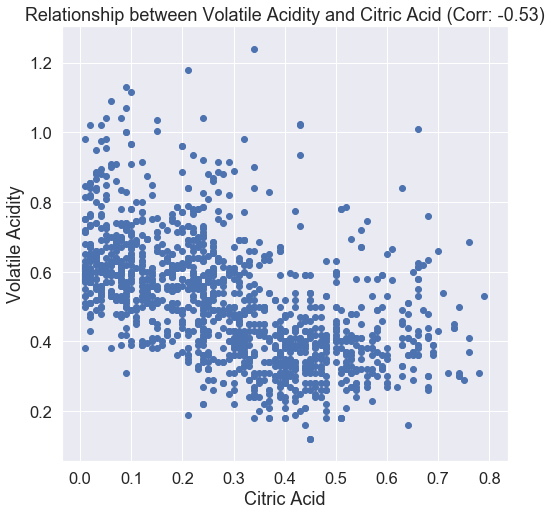

In [15]:
corr = 'Corr: %.2f' % df['volatile acidity'].corr(df['citric acid'])
corr_plot(df['citric acid'], 'Citric Acid', df['volatile acidity'], 'Volatile Acidity', 
          'Relationship between Volatile Acidity and Citric Acid ({})'.format(corr))

Volatile acidity has a negative correlation with citric acid. This means that as citric acid increases, volatile acidity decreases. From the point, a few outliers are spotted that don't generalize to the negative correlation. Points at greater and 1.2 (volatile acidity), 1.18 (volatile acidity) and 1.01 (volatile acidity) will be removed.

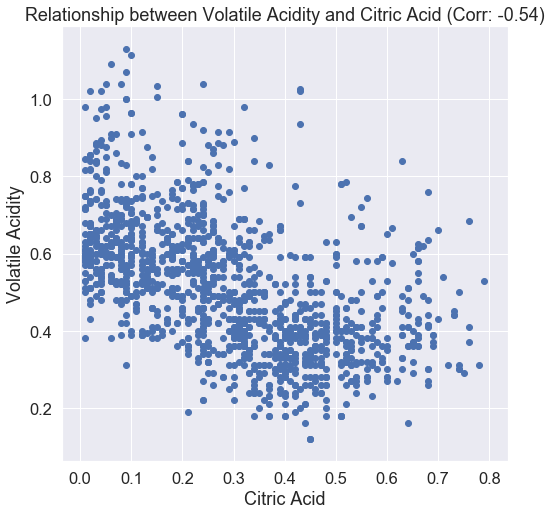

In [16]:
df = df[df['volatile acidity'] < 1.2]
df = df[df['volatile acidity'] != 1.18]
df = df[df['volatile acidity'] != 1.01]

corr = 'Corr: %.2f' % df['volatile acidity'].corr(df['citric acid'])
corr_plot(df['citric acid'], 'Citric Acid', df['volatile acidity'], 'Volatile Acidity', 
          'Relationship between Volatile Acidity and Citric Acid ({})'.format(corr))

#### Citric Acid & pH ####

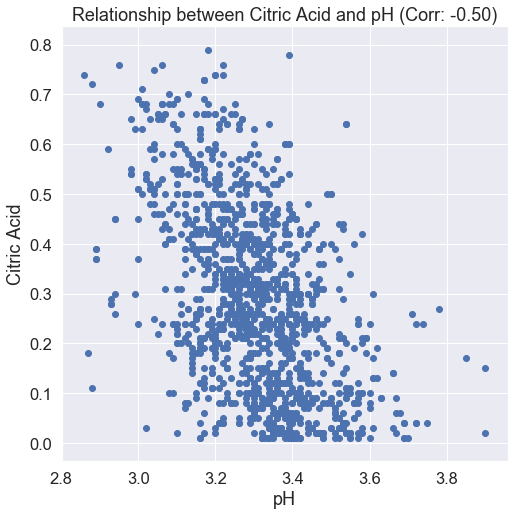

In [17]:
corr = 'Corr: %.2f' % df['citric acid'].corr(df['pH'])
corr_plot(df['pH'], 'pH', df['citric acid'], 'Citric Acid', 
          'Relationship between Citric Acid and pH ({})'.format(corr))

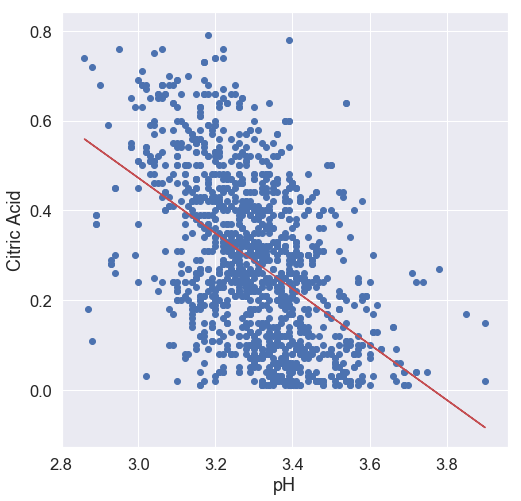

In [18]:
plot_relationship_best_fit(df['pH'], 'pH', df['citric acid'], 'Citric Acid')

The point at which citric acid is 0.78 will be removed.

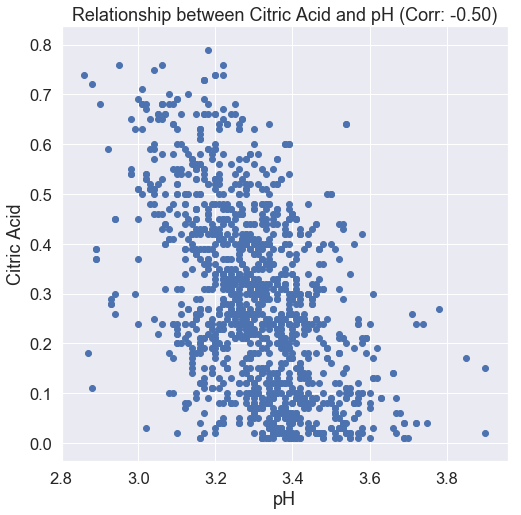

In [19]:
df = df[df['citric acid'] != 0.78]

corr = 'Corr: %.2f' % df['citric acid'].corr(df['pH'])
corr_plot(df['pH'], 'pH', df['citric acid'], 'Citric Acid', 
          'Relationship between Citric Acid and pH ({})'.format(corr))

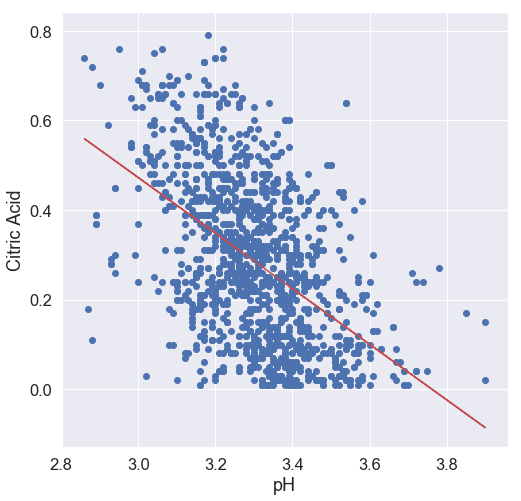

In [20]:
plot_relationship_best_fit(df['pH'], 'pH', df['citric acid'], 'Citric Acid')

#### Density & Fixed Acidity ####

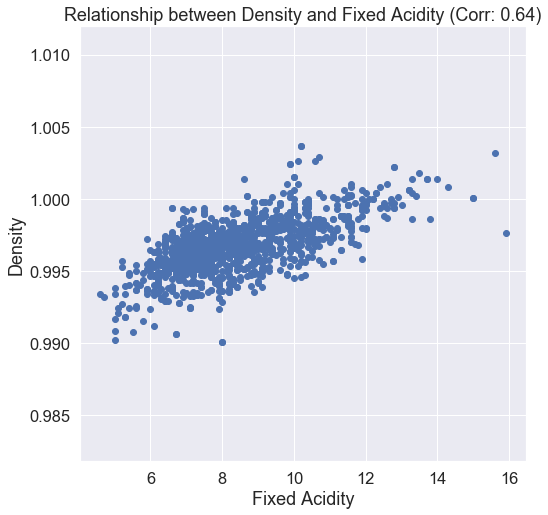

In [21]:
corr = 'Corr: %.2f' % df['density'].corr(df['fixed acidity'])
corr_plot(df['fixed acidity'], 'Fixed Acidity', df['density'], 'Density', 
          'Relationship between Density and Fixed Acidity ({})'.format(corr))

Points a which density is greater than 0.991 and fixed acidity is 15.9 will be removed.

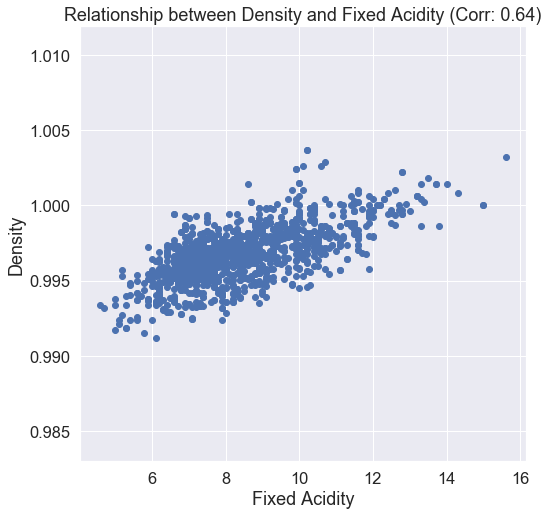

In [22]:
df = df[df['density'] > 0.991]
df = df[df['fixed acidity'] != 15.9]

corr_plot(df['fixed acidity'], 'Fixed Acidity', df['density'], 'Density', 
          'Relationship between Density and Fixed Acidity ({})'.format(corr))

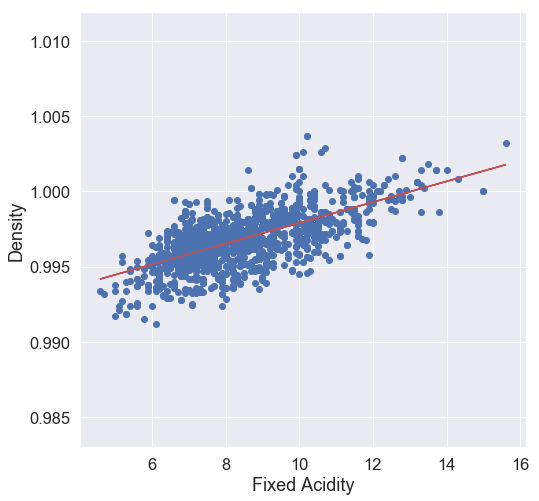

In [23]:
plot_relationship_best_fit(df['fixed acidity'], 'Fixed Acidity', df['density'], 'Density')

#### Density & Alcohol ####

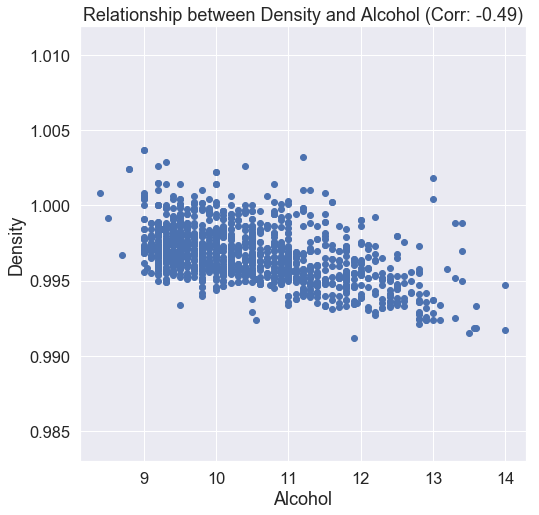

In [24]:
corr = 'Corr: %.2f' % df['density'].corr(df['alcohol'])
corr_plot(df['alcohol'], 'Alcohol', df['density'], 'Density', 
          'Relationship between Density and Alcohol ({})'.format(corr))

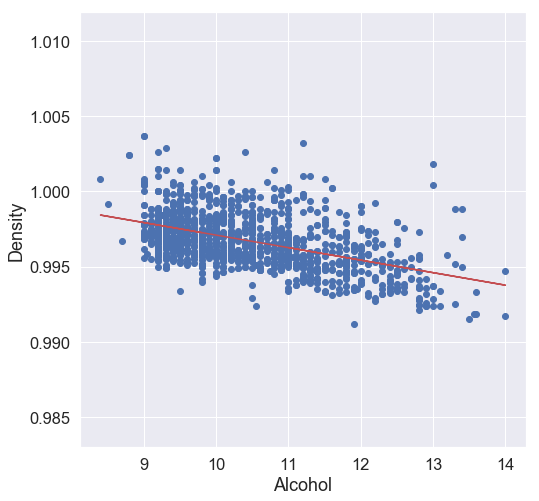

In [25]:
plot_relationship_best_fit(df['alcohol'], 'Alcohol', df['density'], 'Density')

#### pH & Fixed Acidity ####

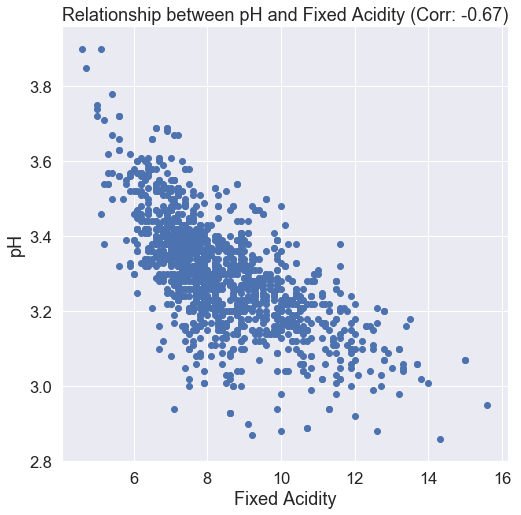

In [26]:
corr = 'Corr: %.2f' % df['pH'].corr(df['fixed acidity'])
corr_plot(df['fixed acidity'], 'Fixed Acidity', df['pH'], 'pH', 
          'Relationship between pH and Fixed Acidity ({})'.format(corr))

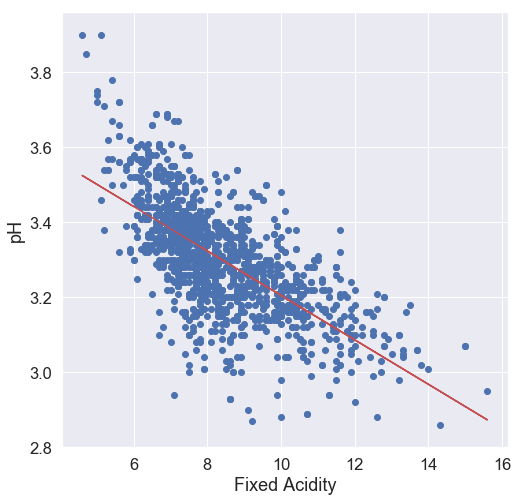

In [27]:
plot_relationship_best_fit(df['fixed acidity'], 'Fixed Acidity', df['pH'], 'pH')

#### Free Sulfur Dioxide & Total Sulfur Dioxide ####

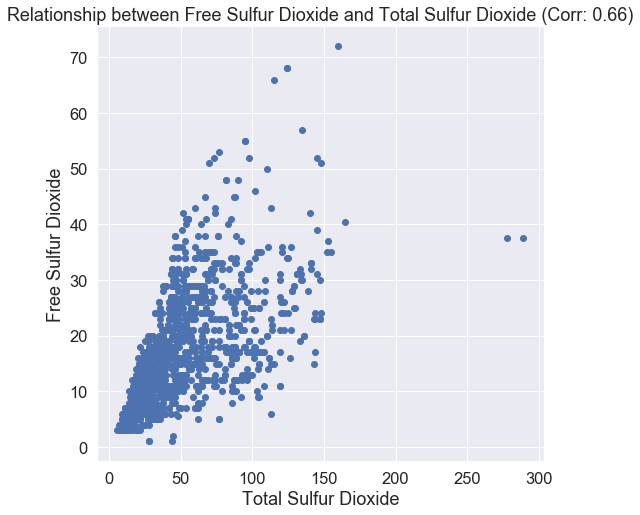

In [28]:
corr = 'Corr: %.2f' % df['free sulfur dioxide'].corr(df['total sulfur dioxide'])
corr_plot(df['total sulfur dioxide'], 'Total Sulfur Dioxide', df['free sulfur dioxide'], 'Free Sulfur Dioxide', 
          'Relationship between Free Sulfur Dioxide and Total Sulfur Dioxide ({})'.format(corr))

Clearly, total sulfur dioxide points greater than 250 are outliers.

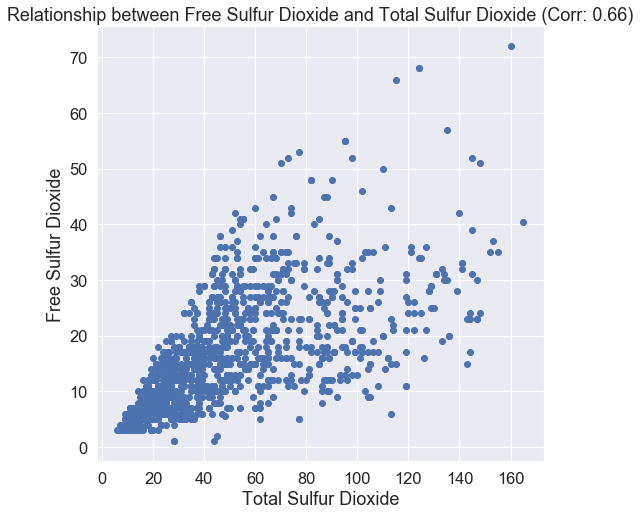

In [29]:
df = df[df['total sulfur dioxide'] < 250]

corr_plot(df['total sulfur dioxide'], 'Total Sulfur Dioxide', df['free sulfur dioxide'], 'Free Sulfur Dioxide', 
          'Relationship between Free Sulfur Dioxide and Total Sulfur Dioxide ({})'.format(corr))

In [30]:
df.shape

(1384, 12)

# Feature Engineering #

Features will be engineered to create new features based on the relationship between the features and their correlation. From research, total acidity is made up of fixed acidity and volatile acidity. These features will be combined to one feature. Features that have a correlation greater than 0.4 will be combined to form new features.

In [31]:
df['total acidity'] = df['fixed acidity'] + df['volatile acidity']
df['fixed acidity citric acid'] = df['fixed acidity'] * df['citric acid']
df['fixed acidity density'] = df['fixed acidity'] * df['density']
df['fixed acidity pH'] = df['fixed acidity'] * df['pH']
df['volatile acidity citric acid'] = df['volatile acidity'] * df['citric acid']
df['citric acid pH'] = df['citric acid'] * df['pH']
df['sulfur dioxide content'] = df['total sulfur dioxide'] * df['free sulfur dioxide']
df['alcohol density'] = df['alcohol'] * df['density']
df['alcohol quality'] = df['alcohol'] * df['quality']


df.drop(['fixed acidity', 'volatile acidity', 'citric acid', 'density', 'pH', 'total sulfur dioxide', 
         'free sulfur dioxide', 'alcohol'], axis=1, inplace=True)
df = df.reset_index(drop=True)

In [55]:
df

,residual sugar,chlorides,sulphates,quality,total acidity,fixed acidity citric acid,fixed acidity density,fixed acidity pH,volatile acidity citric acid,citric acid pH,sulfur dioxide content,alcohol density,alcohol quality
0,2.3,0.092,0.65,5,8.560,0.312,7.776600,25.428,0.03040,0.1304,810.0,9.770600,49.0
1,1.9,0.075,0.58,6,11.480,6.272,11.177600,35.392,0.15680,1.7696,1020.0,9.780400,58.8
2,1.6,0.069,0.46,5,8.500,0.474,7.871560,26.070,0.03600,0.1980,885.0,9.366160,47.0
3,2.0,0.073,0.57,7,8.380,0.156,7.775040,26.208,0.01160,0.0672,162.0,9.469600,66.5
4,6.1,0.071,0.80,5,8.000,2.700,7.483500,25.125,0.18000,1.2060,1734.0,10.476900,52.5
5,1.8,0.097,0.54,5,7.280,0.536,6.672530,21.976,0.04640,0.2624,975.0,9.162280,46.0
6,6.1,0.071,0.80,5,8.000,2.700,7.483500,25.125,0.18000,1.2060,1734.0,10.476900,52.5
7,1.6,0.114,1.56,5,8.410,2.262,7.779720,25.428,0.17690,0.9454,261.0,9.076340,45.5
8,3.8,0.176,0.88,5,9.520,1.602,8.887540,28.124,0.11160,0.5688,7540.0,9.187120,46.0
9,3.9,0.170,0.93,5,9.520,1.691,8.887540,28.213,0.11780,0.6023,7548.0,9.187120,46.0


In [56]:
random_state = 42
target = df['quality']
features = df.drop('quality', axis=1)
features.shape

(1384, 12)

In [57]:
df.shape

(1384, 13)

# Feature Scaling #

With outliers removed, the dataset will be scaled using the `StandardScaler` class. But first the data will be split into training and testing sets with a ration of 75% to 25%.

In [35]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.25, random_state=random_state)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(1038, 12)
(346, 12)
(1038,)
(346,)


In [58]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Train model #

The model will be trained on the default hyperparameters of `Linear Regressor`, `Ridge`, `Lasso`, `ElasticNet`, `Random Forest Regressor`, `Gradient Boosting Regressor`, `Ada Boost Regressor`, `Decision Tree Regressor` and `Support Vector Regressor`.

The performance of the model will be evaluated using its `r2 score`.

In [59]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.svm import SVR

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

cv = KFold(n_splits=10, shuffle=True, random_state=random_state)

def experimentation_scores(scores):
    return scores.mean()

### Decision Tree Regressor ###

In [61]:
model = DecisionTreeRegressor(random_state=random_state)
scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='r2')
dtr_score = experimentation_scores(scores)

### Linear Regressor ###

In [62]:
model = LinearRegression()
scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='r2')
lr_score = experimentation_scores(scores)

### Ridge ###

In [63]:
model = Ridge(random_state=random_state)
scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='r2')
ri_score = experimentation_scores(scores)

### Lasso ###

In [64]:
model = Lasso(random_state=random_state)
scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='r2')
la_score = experimentation_scores(scores)

### ElasticNet ###

In [65]:
model = ElasticNet(random_state=random_state)
scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='r2')
el_score = experimentation_scores(scores)

### Gradient Boosting Regressor ###

In [66]:
model = GradientBoostingRegressor(random_state=random_state)
scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='r2')
gbr_score = experimentation_scores(scores)

### Random Forest Regressor ###

In [67]:
model = RandomForestRegressor(random_state=random_state)
scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='r2')
rfr_score = experimentation_scores(scores)

C:\Users\leety\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\leety\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\leety\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\leety\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\leety\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: F

### Ada Boost Regressor ###

In [68]:
model = AdaBoostRegressor(random_state=random_state)
scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='r2')
abr_score = experimentation_scores(scores)

### SVR ###

In [69]:
model = SVR()
scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='r2')
svr_score = experimentation_scores(scores)

C:\Users\leety\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\leety\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\leety\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\leety\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarni

Plot default performance.

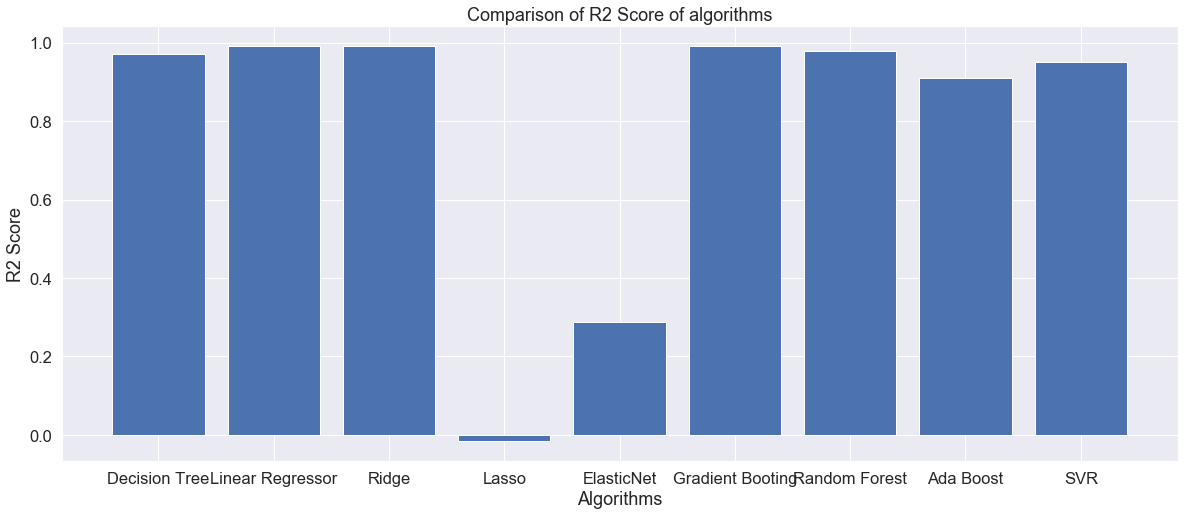

In [70]:
x = np.arange(9)
plt.figure(figsize=(20, 8))
plt.bar(x, [dtr_score, lr_score, ri_score, la_score, el_score, gbr_score, rfr_score, abr_score, svr_score])
plt.xticks(x, ('Decision Tree', 'Linear Regressor', 'Ridge', 'Lasso', 'ElasticNet', 'Gradient Booting', 'Random Forest', 
               'Ada Boost', 'SVR'))
plt.title('Comparison of R2 Score of algorithms')
plt.xlabel('Algorithms')
plt.ylabel('R2 Score')
plt.show()

Using default values, `LinearRegressor`, `Ridge` and `GradientBoostingRegressor` performs better than the other algorithms. Since there are 3 options to choose from, `LinearRegressor` will be used to trian the model.

# Train a linear regressor model #

In [71]:
model = LinearRegression()

A learning curve is plotted to see how well the model learns the dataset without overfitting and underfitting.

In [72]:
from sklearn.model_selection import learning_curve

scoring = 'r2'
n_jobs = -1
train_sizes, train_scores, val_scores = learning_curve(model, X_train, y_train, cv=cv, 
                                                         scoring=scoring, n_jobs=n_jobs, verbose=1)
train_scores_mean = np.mean(train_scores, axis=1)
val_scores_mean = np.mean(val_scores, axis=1)

[learning_curve] Training set sizes: [ 93 303 513 723 934]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.0s finished


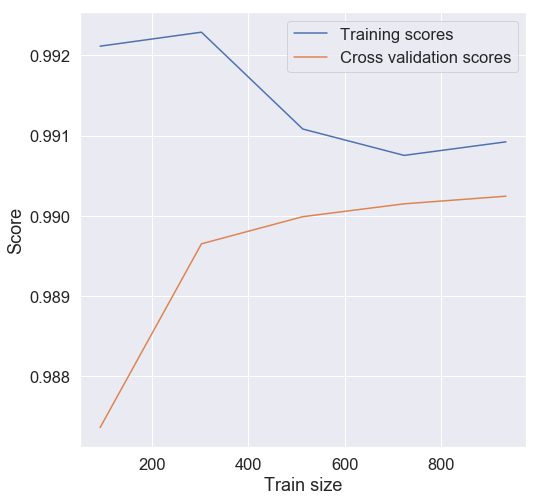

In [73]:
plt.figure(figsize=(8, 8))
plt.plot(train_sizes, train_scores_mean, label='Training scores')
plt.plot(train_sizes, val_scores_mean, label='Cross validation scores')
plt.xlabel('Train size')
plt.ylabel('Score')
plt.legend()
plt.show()

### Fit model and make predictions ###

In [78]:
model.fit(X_train, y_train)
predictions = model.predict(X_test)
predictions

array([5.04559487, 5.02497855, 5.05065207, 5.06489241, 6.82673453,
       7.23581188, 7.10998594, 4.230325  , 6.91921171, 5.04926911,
       6.90660566, 5.01433473, 6.0204567 , 4.91116811, 4.97586447,
       5.92513958, 5.99106235, 8.3041788 , 5.9611472 , 5.95885326,
       5.04154229, 6.87678012, 5.94743981, 5.95625736, 5.94553141,
       5.96089971, 5.98417692, 5.04422093, 4.9546378 , 7.13054505,
       4.90175119, 5.93394174, 6.9468654 , 5.01451453, 5.98269444,
       5.02248412, 5.94943218, 7.13522373, 4.97172368, 5.06873661,
       5.99758109, 5.06133849, 3.93749237, 5.92776109, 5.97330938,
       5.00395211, 4.92620999, 5.99582525, 5.97728339, 6.941833  ,
       5.07002063, 5.04198633, 5.00982539, 5.95424049, 4.78195788,
       6.94127024, 5.9811284 , 7.12233382, 4.97985067, 7.14905009,
       5.04034825, 5.9636995 , 5.93527191, 5.9533158 , 5.07368172,
       4.94325276, 5.96898727, 4.98165482, 5.04534862, 4.97180552,
       5.95661676, 5.91342921, 7.00584915, 4.12785265, 5.96972

# Evaluate the model #

In [79]:
score = model.score(X_test, y_test)
print('Score: %.3f' % score)

Score: 0.990


The plot below compares the predictions of the model with the corresponding ground-truth values.

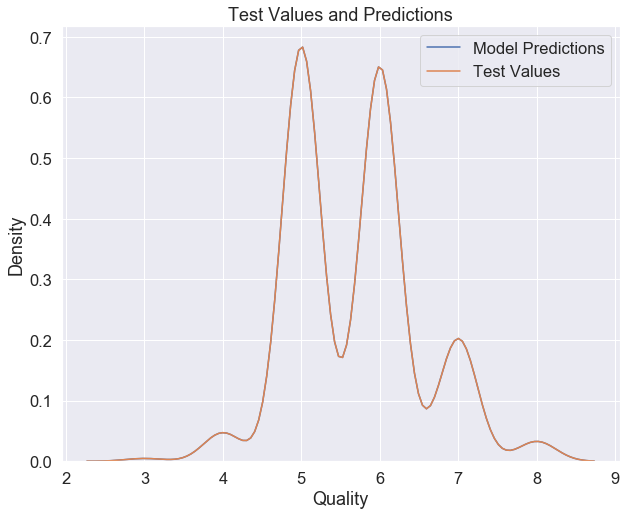

In [80]:
def evaluation_plot(y_test, predictions):
    plt.figure(figsize=(10, 8))

    # Density plot of the final predictions and the test values
    sns.kdeplot(predictions, label='Model Predictions')
    sns.kdeplot(y_test, label='Test Values')

    # Label the plot
    plt.xlabel('Quality')
    plt.ylabel('Density')
    plt.title('Test Values and Predictions')
    plt.show()

evaluation_plot(y_test, np.round(predictions))